In [1]:
import numpy as np
import pandas as pd
import torch
from bisect import bisect
import os, psutil # used to monitor memory usage
from glob import glob
import pylab as pl
from PIL import Image

from tqdm.notebook import tqdm

In [2]:
from torch            import FloatTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision      import transforms

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
# import sys
# sys.path.insert(0,'/global/homes/j/jfsuarez/.local/perlmutter/pytorch1.9.0/lib/python3.8/site-packages/')
# from einops.layers.torch import Rearrange, Reduce

In [4]:
pl.style.use('../../plots.mplstyle')

In [5]:
class ReadDataset(Dataset):
    def __init__(self, predictor_paths, target_paths):
        self.predictor_files = predictor_paths
        self.target_files = target_paths
        
        self.data_transforms = transforms.Compose([
            # transforms.Resize(256),
            transforms.ToTensor()
            ])
    
    def __getitem__(self, index):
        x = np.load(self.predictor_files[index])
        # x = Image.fromarray(x, 'RGB')
        x = self.data_transforms(x)
        
        y = np.load(self.target_files[index])[0] #- Get only the first feature 0:Redshift
        y = torch.tensor(y).float()
        return x, y
    
    def __len__(self):
        return len(self.predictor_files)

In [6]:
def tensor2img(tensor):
    return transforms.ToPILImage()(tensor)

In [7]:
def patchify(images, n_patches):
    n, c, h, w = images.shape
    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patches[idx, i * n_patches + j] = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size].flatten()
    return patches

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

def patch_example(image, n_patches):
    c, h, w = image.shape
    assert h == w, "Patchify method is implemented for square images only"

    patch = np.zeros(n_patches**2, dtype=object)
    patch_size = h // n_patches
    
    idx = 0
    for i in range(n_patches):
        for j in range(n_patches):
            patch[idx] = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            idx += 1
            
    return patch

In [8]:
# Test Code
#- Path to all the image files
images = np.sort(glob('../../data/catalog_fuji_sv3_bgs/npy/*photogrz*.npy'))[:10000]

#- Path to all the features files
# targets = np.sort(glob('./catalog_fuji_sv3_bgs/npy/*features*.npy'))
targets = np.array([i.replace('photogrz','features') for i in images])

#- Number of objects
N = len(images)
print(f'#####\n There are {N} objects\n#####')

ii       = np.random.choice(range(N), N, replace=False)
ii_train = ii[:int(N*.7)]
ii_valid  = ii[int(N*.7):int(N*.9)]
ii_test  = ii[int(N*.9):]

img_train_files = images[ii_train]
tgt_train_files = targets[ii_train]

img_valid_files = images[ii_valid]
tgt_valid_files = targets[ii_valid]

img_test_files = images[ii_test]
tgt_test_files = targets[ii_test]

print(f'#####\n Train Size: {len(img_train_files)}')
print(f'Valid Size: {len(img_valid_files)}')
print(f'Test Size:{len(img_test_files)}\n#####')

train_dataset = ReadDataset(img_train_files, tgt_train_files)
valid_dataset = ReadDataset(img_valid_files, tgt_valid_files)
test_dataset  = ReadDataset(img_test_files, tgt_test_files)

#####
 There are 10000 objects
#####
#####
 Train Size: 7000
Valid Size: 2000
Test Size:1000
#####


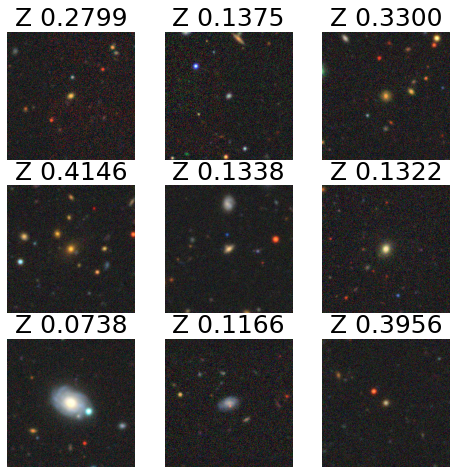

In [9]:
figure = pl.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, tgt = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    pl.title(f'Z {tgt:.4f}')
    pl.axis("off")
    pl.imshow(tensor2img(img))
pl.show()

In [10]:
#- Define the batch_size
batch_size = 126
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset,  batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

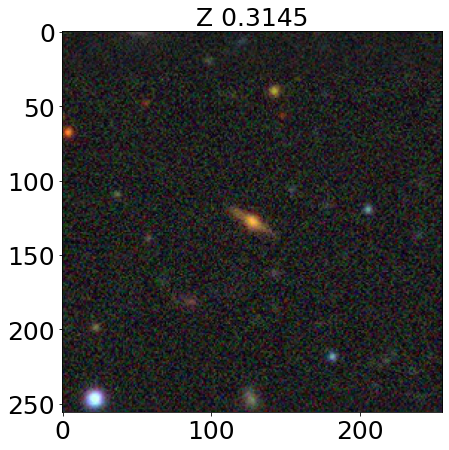

In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]
pl.title(f'Z {label:.4f}')
pl.imshow(tensor2img(img))
pl.show()

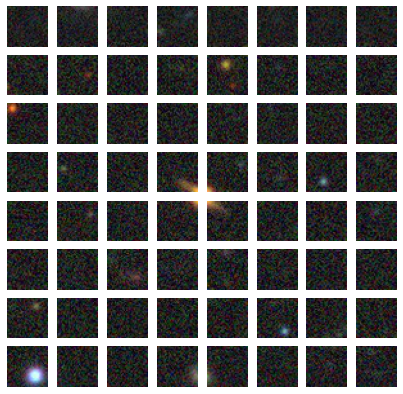

In [12]:
n_patch = 8
patches_ex = patch_example(img, n_patch)
for i, pex in enumerate(patches_ex):
    pl.subplot(n_patch, n_patch, i+1)
    pl.imshow(tensor2img(pex))
    pl.axis(False)
pl.show()

In [13]:
class MSA(torch.nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = torch.nn.ModuleList([torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = torch.nn.ModuleList([torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = torch.nn.ModuleList([torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head  = d_head
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [14]:
class ViTBlock(torch.nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads  = n_heads

        self.norm1 = torch.nn.LayerNorm(hidden_d)
        self.mhsa  = MSA(hidden_d, n_heads)
        self.norm2 = torch.nn.LayerNorm(hidden_d)
        self.mlp   = torch.nn.Sequential(
            torch.nn.Linear(hidden_d, mlp_ratio * hidden_d),
            torch.nn.GELU(),
            torch.nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x   + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [15]:
class ViT(torch.nn.Module):
    def __init__(self, chw, n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        super(ViT, self).__init__()
        
        # Attributes
        self.chw       = chw          #(C, H, W)
        self.n_patches = n_patches
        self.hidden_d  = hidden_d
        self.n_blocks  = n_blocks
        self.n_heads   = n_heads
        self.out_d     = out_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        
        # 1) Lineae mapper
        self.input_d        = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper  = torch.nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token    = torch.nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)        
        
        # 4) Transformer encoder blocks
        self.blocks = torch.nn.ModuleList([ViTBlock(self.hidden_d, self.n_heads) for _ in range(self.n_blocks)])
        
        # 5) Regression Layer
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_d, self.out_d)
            )
        
    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens  = self.linear_mapper(patches)
                
        # Adding classification token to the tokens
        tokens = torch.stack([ torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens)) ])
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the prediction
        out = self.mlp(out[:, 0])
        
        return out

In [16]:
# model = ViT(chw=(3,256,256), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=1)

# x = torch.randn(7,3,256,256) # Fake images
# print(model(x).shape)

In [17]:
def train(model, epoch, dataloader, device, optimizer, criterion):
    model.train()
    
    #- Start the train loop
    for batch_id, (X_batch, Y_batch) in enumerate(dataloader):
        
        #- Send data to device 
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        #- Make the prediction
        Y_pred = model(X_batch).squeeze()

        #- Compute the loss
        loss = criterion(Y_pred, Y_batch)

        #- Back Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1} - Loss_Train:{loss.item():.4f}')        
    return loss.item()

def test(model, epoch, dataloader, device, criterion):
    model.eval()
    
    #- Start the test loop
    for batch_id, (X_batch, Y_batch) in enumerate(dataloader):
        
        #- Send data to device 
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        #- Make the prediction
        Y_pred = model(X_batch).squeeze()

        #- Compute the loss
        loss = criterion(Y_pred, Y_batch)

    print(f'Epoch:{epoch+1} - Loss_Test:{loss.item():.4f}')        
    return loss.item()

In [18]:
# model = ViT(chw=(3,256,256), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=1)
# model

In [19]:
def main():
    #- Set parameters
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--lr', type=int, default=1e-3,
#                         help='Learning Rate')

#     parser.add_argument('--epochs', type=int, default=100,
#                         help='Maximum number of epochs (default: 300)')
    
#     parser.add_argument('--batch', type=int, default=16,
#                     help='Batch size (default: 13)')
    
#     parser.add_argument('--name', type=str, default='Test',
#                         help='Name of the current test (default: Test)')
    
#     parser.add_argument('--model', type=str, default='ViT',
#                         help='Name model')
    
#     parser.add_argument('--label', type=str, default='Test',
#                         help='Label to compare runnings')
    
#     parser.add_argument('--catalog', type=str, default=None, 
#                         help='Name of the folder with the data')
    
    
#     parser.add_argument('--patches', type=float, default=8,
#                             help='Number of patches')    
    
#     parser.add_argument('--blocks', type=int, default=2,
#                         help='Number of Attention blocks')
    
#     parser.add_argument('--hidden_d', type=float, default=8, 
#                         help='Dropout probability')
    
#     parser.add_argument('--heads', type=float, default=8, 
#                         help='Number of heads')
    
    #parser.add_argument('--load_model', type=str, default='best_f1', help='Weights to load (default: best_f1)')
    #parser.add_argument('--test', action='store_false', default=True, help='Only test the model')
    #parser.add_argument('--resume', action='store_true', default=False, help='Continue training a model')
    #parser.add_argument('--ft', action='store_true', default=False, help='Fine-tune a model')
    #parser.add_argument('--freeze', action='store_false', default=True, help='Freeze weights of the model')
    #parser.add_argument('--gpu', type=str, default='0', help='GPU(s) to use (default: 0)')
    #parser.add_argument('--amp', action='store_true', default=False,help='Train with automatic mixed precision')
    
    # args = parser.parse_args()
    
    name   = 'test'
    label  = 'ViT'
    catalog = 'guadalupe_stats_Z0.5.csv'
    batch = 16
    lr = 0.01
    epochs = 10
    
    save_path = os.path.join('train', name, label)
    # save_path = os.path.join('train', args.name, args.label)
    if not os.path.isdir(save_path):
        os.makedirs(save_path, exist_ok=True)
    
    data = pd.read_csv(catalog)
    # data = pd.read_csv(args.catalog)

    img_train_files = data['IMAGE_FILE'][np.array(data['MODEL_LABEL'], dtype=int)==0][:7000].values.tolist()
    tgt_train_files = [i.replace('photogrz','features') for i in img_train_files]

    img_valid_files = data['IMAGE_FILE'][np.array(data['MODEL_LABEL'], dtype=int)==1][:2000].values.tolist()
    tgt_valid_files = [i.replace('photogrz','features') for i in img_valid_files]

    img_test_files = data['IMAGE_FILE'][np.array(data['MODEL_LABEL'], dtype=int)==2][:1000].values.tolist()
    tgt_test_files = [i.replace('photogrz','features') for i in img_test_files]

    #- Number of objects
    N = len(img_train_files)+len(img_valid_files)+len(img_test_files)
    print(f'#####\n There are {N} objects\n#####')

    print(f'#######\n Train Size: {len(img_train_files)}')
    print(f' Valid  Size: {len(img_valid_files)}')
    print(f' Test  Size: {len(img_test_files)}\n#######')

    train_dataset = ReadDataset(img_train_files, tgt_train_files)
    valid_dataset = ReadDataset(img_valid_files, tgt_valid_files)
    test_dataset  = ReadDataset(img_test_files,  tgt_test_files)

    # sample_idx = torch.randint(0, len(train_dataset), size=(9,)).detach().numpy()
    # figure = pl.figure(figsize=(8, 8))
    # cols, rows = 3, 3
    # for i in range(0, cols * rows):
    #     spec, tgt = train_dataset[sample_idx[i]]
    #     figure.add_subplot(rows, cols, i+1)
    #     pl.title(f'Z {tgt.item():.4f}')
    #     pl.plot(spec.squeeze())
    # print(f'Size {len(spec.squeeze())}')
    # pl.tight_layout()
    # pl.savefig()
    # pl.show()
    
    #- Define the batch_size
    batch_size = batch
    # batch_size = args.batch
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)
    
    # train_features, train_labels = next(iter(train_dataloader))
    #- Display image and label
    # spec = train_features[0].squeeze().detach().numpy()
    # label = train_labels[0].item()
    # pl.title(f'Z {label:.4f}')
    # pl.plot(spec)
    # pl.show()

    #- Define the device cpu/gpu
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    print(device)

    #- Define the model
    model = ViT(chw=(3,256,256), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=1)
    print('---> Number of params: {}'.format(sum([p.data.nelement() for p in model.parameters()])))
    
    #- Send the model to the device
    model = model.to(device)
   
    #- Define the optimizer and the criterion
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
    criterion = torch.nn.MSELoss()
    
    
    loss_train = []
    loss_valid = []
    
    #- Running name
    name = name
    # name = args.name
    for epoch in range(epochs):
    # for epoch in range(args.epochs):
        loss_train.append( train(model, epoch, train_dataloader, device, optimizer, criterion) )
        loss_valid.append(  test(model, epoch, valid_dataloader, device, criterion) )

    fig = pl.figure(figsize=(8,4))
    pl.plot(loss_train, label='Train')
    pl.plot(loss_valid, label='Valid')
    pl.legend()
    pl.savefig(f'{save_path}/Loss_RegPhoto_{name}.png', bbox_inches='tight')
    # pl.show()

    torch.save(model, f'{save_path}/{name}.pt')
    
    #- Put the model on test mode
    model.eval()
    with torch.no_grad():
        Y_pred = []
        Y_test = []
        for batch_idx, (data, target) in enumerate(test_dataloader):    
            data = FloatTensor(data)
            target = FloatTensor(target)
            data   = data.to(device)
            target = target.to(device)        
            Y_pred.append(model(data).cpu().squeeze().detach().numpy())
            Y_test.append(target.cpu().detach().numpy())
        Y_predtest = np.concatenate([np.ravel(i) for i in Y_pred])
        Y_test = np.concatenate([np.ravel(i) for i in Y_test])

        Y_pred = []
        Y_train = []    
        for batch_idx, (data, target) in enumerate(train_dataloader):    
            data = FloatTensor(data)
            target = FloatTensor(target).view(len(target), -1)
            data   = data.to(device)
            target = target.to(device)        
            Y_pred.append(model(data).cpu().squeeze().detach().numpy())
            Y_train.append(target.cpu().detach().numpy())
        Y_predtrain = np.concatenate([np.ravel(i) for i in Y_pred])
        Y_train = np.concatenate([np.ravel(i) for i in Y_train])

    fig = pl.figure(figsize=(20,5))
    pl.subplot(1,3,1)
    pl.scatter(Y_predtest, Y_test, alpha=0.5)
    maxx = max(max(Y_predtest),max(Y_test))
    pl.plot([0, maxx], [0, maxx], '--')
    pl.xlabel(r'$z_{pred}$')
    pl.ylabel(r'$z_{test}$')
    pl.title(r'$z_{pred}$ - $z_{test}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_test, Y_predtest):.3f}   -    MSE={mean_squared_error(Y_test, Y_predtest):.4f}')
    pl.subplot(1,3,2)
    _ = pl.hist(Y_predtest - Y_test, label=r'$z_{pred}$ - $z_{test}$', alpha=0.5)
    pl.legend()
    pl.subplot(1,3,3)
    _ = pl.hist(Y_predtest, label='Pred', alpha=0.5)
    _ = pl.hist(Y_test, label='Test', alpha=0.5)
    pl.legend()
    pl.savefig(f'{save_path}/RegPhoto_test_{name}.png', bbox_inches='tight')
    
    
    fig = pl.figure(figsize=(20,5))
    pl.subplot(1,3,1)
    pl.scatter(Y_predtrain, Y_train, alpha=0.5)
    maxx = max(max(Y_predtrain),max(Y_train))
    pl.plot([0, maxx], [0, maxx], '--')
    pl.xlabel(r'$z_{pred}$')
    pl.ylabel(r'$z_{train}$')
    pl.title(r'$z_{pred}$ - $z_{train}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_train, Y_predtrain):.3f}   -    MSE={mean_squared_error(Y_train, Y_predtrain):.4f}')
    pl.subplot(1,3,2)
    _ = pl.hist(Y_predtrain - Y_train, label=r'$z_{pred}$ - $z_{train}$', alpha=0.5)
    pl.legend()
    pl.subplot(1,3,3)
    _ = pl.hist(Y_predtrain, label='Pred', alpha=0.5)
    _ = pl.hist(Y_train, label='train', alpha=0.5)
    pl.legend()
    pl.savefig(f'{save_path}/RegPhoto_train_{name}.png', bbox_inches='tight')

#####
 There are 10000 objects
#####
#######
 Train Size: 7000
 Valid  Size: 2000
 Test  Size: 1000
#######
cuda:0
---> Number of params: 26009
Epoch:1 - Loss_Train:0.0072
Epoch:1 - Loss_Test:0.0116
Epoch:2 - Loss_Train:0.0189
Epoch:2 - Loss_Test:0.0141
Epoch:3 - Loss_Train:0.0156
Epoch:3 - Loss_Test:0.0088
Epoch:4 - Loss_Train:0.0085
Epoch:4 - Loss_Test:0.0133
Epoch:5 - Loss_Train:0.0105
Epoch:5 - Loss_Test:0.0118
Epoch:6 - Loss_Train:0.0070
Epoch:6 - Loss_Test:0.0111
Epoch:7 - Loss_Train:0.0033
Epoch:7 - Loss_Test:0.0122
Epoch:8 - Loss_Train:0.0099
Epoch:8 - Loss_Test:0.0207
Epoch:9 - Loss_Train:0.0120
Epoch:9 - Loss_Test:0.0115
Epoch:10 - Loss_Train:0.0066
Epoch:10 - Loss_Test:0.0095


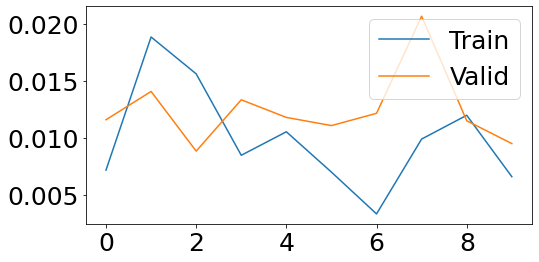

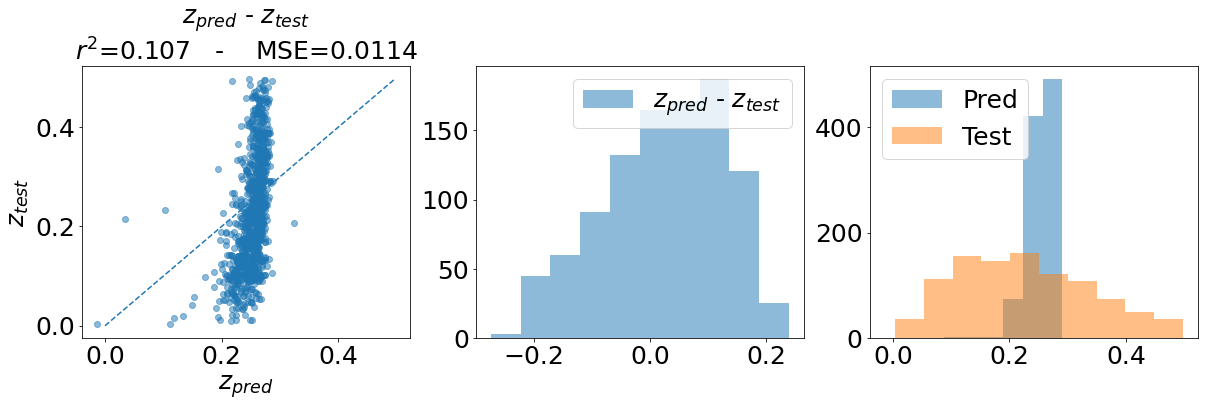

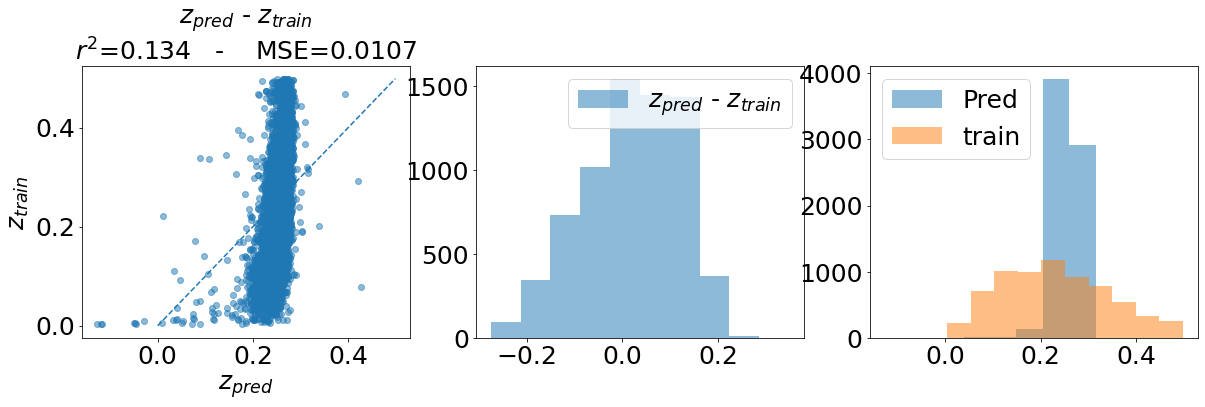

In [20]:
main()